Let's get right into this post! But, before you read this post, be sure to check out my original post on [word embeddings](https://jrtechs.net/data-science/word-embeddings). In this post we will be using data from this blog to create and visualize a word embedding.

To recap, let's first look at a small example using the [Gensim](https://pypi.org/project/gensim/) Word2Vec model:

In [156]:
from gensim.models import Word2Vec

# defines some dummy data
sentences = [["cat", "say", "meow"], ["dog", "say", "woof"], ["man", "say", "dam"]]

# creates and trains model
model = Word2Vec(min_count=1, size=10)
model.build_vocab(sentences)
model.train(sentences, total_examples=model.corpus_count, epochs=model.epochs) 

# saves the model so that you can load it later with model.load
model.save("basic-word2vec.model")

With this word2vec model we can do things like get the most similar words and get the vectorized version of the word. 

In [114]:
model.wv.most_similar("dog")

[('woof', 0.3232297897338867),
 ('dam', 0.14384251832962036),
 ('man', 0.11316978931427002),
 ('cat', -0.06251632422208786),
 ('say', -0.1781214326620102),
 ('meow', -0.21009384095668793)]

In [14]:
print(model.wv.get_vector("dog"))

[ 0.04777663  0.01543251 -0.04632503  0.03601828 -0.00572644  0.00553683
 -0.04476452 -0.0274465   0.0047655   0.00508591]


Using the TSNE method, we can reduce the dimensionality so that we can visualize it.

In [158]:
from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction
import numpy as np                      

def reduce_dimensions(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    vectors = [] # positions in vector space
    labels = [] # keep track of words to label our data again later
    for word in model.wv.vocab:
        vectors.append(model.wv[word])
        labels.append(word)

    # convert both lists into numpy vectors for reduction
    vectors = np.asarray(vectors)
    labels = np.asarray(labels)

    # reduce using t-SNE
    vectors = np.asarray(vectors)
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels


x_vals, y_vals, labels = reduce_dimensions(model)

In [26]:
print(labels)
print(x_vals)
print(y_vals)

['cat' 'say' 'meow' 'dog' 'woof' 'man' 'dam']
[-29.594002, -45.996586, 20.368856, 53.92877, -12.437127, 3.9659712, 37.524284]
[60.112713, 11.891685, 70.019325, 31.70431, -26.423267, 21.79772, -16.517805]


Due to simplicity, we are using a basic matplotlib scatter plot to visualize it. Since it is messy to visualize every label on larger models, we are reducing the number of labels we are picking to display on the graph. However, on this initial example we can visualize all the labels. 

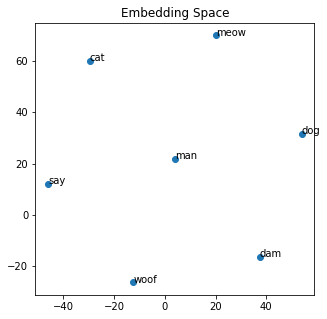

In [161]:
import matplotlib.pyplot as plt
import random

def plot_with_matplotlib(x_vals, y_vals, labels, num_to_label):
    plt.figure(figsize=(5, 5))
    plt.scatter(x_vals, y_vals)
    plt.title("Embedding Space")
    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, num_to_label)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))
    plt.savefig('ex.png')
        
plot_with_matplotlib(x_vals, y_vals, labels, 7)

Since my blog is written in markdown files, we need a way to extract all the code blocks out of it so that our model does not get fooled by things that are not "English."

In [118]:
def process_file(fileName):
    result = ""
    tempResult = ""
    inCodeBlock = False

    with open(fileName) as file:
        for line in file:
            if line.startswith("```"):
                inCodeBlock = not inCodeBlock
            elif inCodeBlock:
                pass
            else:
                for word in line.split():
                    if "http" not in word and "media/"not  in word:
                        result = result  + " " + word
    return result

print(process_file("data/ackermann-function-written-in-java.md"))

 The Ackermann function is a classic example of a function that is not primitive recursive – you cannot solve it using loops like Fibonacci. In other words, you have to use recursion to solve for values of the Ackermann function. For more information on the Ackermann function [click


Although this script takes us most of the way there with removing the code block, we still want to remove stopper words and punctuations. The gensim library has a function that already does that for us.

In [119]:
from gensim import utils
print(utils.simple_preprocess(process_file("data/ackermann-function-written-in-java.md")))

['the', 'ackermann', 'function', 'is', 'classic', 'example', 'of', 'function', 'that', 'is', 'not', 'primitive', 'recursive', 'you', 'cannot', 'solve', 'it', 'using', 'loops', 'like', 'fibonacci', 'in', 'other', 'words', 'you', 'have', 'to', 'use', 'recursion', 'to', 'solve', 'for', 'values', 'of', 'the', 'ackermann', 'function', 'for', 'more', 'information', 'on', 'the', 'ackermann', 'function', 'click']


Loading everything in as memory and feeding it into a large list like the dummy example, although possible, is not feasable or efficient for large data sets. In Gensim it is typical to create a Corpus: a corpus is a collection of documents used for training. To create the corpus baised on my prior blog posts, I need to process each blog post and store the cleaned version in a file.

In [49]:
import os
file = open("jrtechs.cor", "w+")
for file_name in os.listdir("data"):
    file.write(process_file("data/" + file_name) + "\n")
file.close()

To read our text version corpus, we simply create an iterable source that just reads out each line from our text file. In our case each line is an entire blog post.

In [51]:
from gensim.test.utils import datapath

class MyCorpus(object):
    """An interator that yields sentences (lists of str)."""

    def __iter__(self):
        corpus_path = "jrtechs.cor"
        for line in open(corpus_path):
            # assume there's one document per line, tokens separated by whitespace
            yield utils.simple_preprocess(line)

Now we can create a new model using our custom corpus. The things that we will want to change is the embedding size and the number of epochs we train our model.

In [128]:
sentences = MyCorpus()
model = Word2Vec(min_count=1, size=20, sentences=sentences)
model.train(sentences, total_examples=model.corpus_count, epochs=500) 
model.save("jrtechs-word2vec-500.model")

In [130]:
model.wv.most_similar("however")

[('that', 0.7954616546630859),
 ('also', 0.7654829025268555),
 ('but', 0.7392309904098511),
 ('since', 0.7380496859550476),
 ('although', 0.7112778425216675),
 ('why', 0.7025969624519348),
 ('encouragement', 0.6704230308532715),
 ('because', 0.6692429184913635),
 ('faster', 0.6633850932121277),
 ('so', 0.6504907011985779)]

In [139]:
model.wv.most_similar("method")

[('function', 0.8110014200210571),
 ('grouping', 0.7134513854980469),
 ('import', 0.7052735090255737),
 ('select', 0.6987707614898682),
 ('max', 0.6856316328048706),
 ('authentication', 0.6762576103210449),
 ('pseudo', 0.663935124874115),
 ('namespace', 0.6549093723297119),
 ('matrix', 0.6515613198280334),
 ('zero', 0.6360148191452026)]

In [140]:
x_vals, y_vals, labels = reduce_dimensions(model)

If you run the TSNE algorithm with different training parameters, you will get different shapes in your output. I noticed that for my data, If I ran it with 5 epochs I got a curvy shape where if I trained the model with over 100 epochs I just got a single cluster shape. 

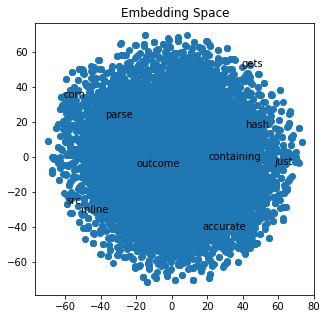

In [155]:
plot_with_matplotlib(x_vals, y_vals, labels, 10)

If we zoom in on the embedding space, we can get a better idea of what clusters close to each other. This visualization of course is not perfect because we are trying to visualize a 15 dimensions down into a two dimensional graph. 

In [152]:
import matplotlib.pyplot as plt
import random

def plot_with_matplotlib(x_vals, y_vals, labels, xmin=3, xmax=7, ymin=3, ymax=7):
    plt.figure(figsize=(5, 5))
    plt.scatter(x_vals, y_vals)
    plt.title("Embedding Space")
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    
    for x, y, l in zip(x_vals, y_vals, labels):
        plt.annotate(l, (x, y))
    plt.savefig('smallex.png')
        
plot_with_matplotlib(x_vals, y_vals, labels)

It was impressive the results I got on my limited data scope. The Google news dataset explored last time was far more accurate, however, the model was quite large and I was unable to run the TSNE algorithm on it without crashing my computer. Training your own word embedding model is useful because in different applications and contexts words can mean different things. Right now there is a large push at seeing how we can leverage pre-trained models. This enables you to take google's word2vec model trained on 100 billion words and tweak the model using your own data to better fit your own application. Maybe I'll make that a part three of this blog post series on embeddings.  